In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [2]:
from sklearn.metrics import balanced_accuracy_score

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
import pandas as pd
import pickle

In [5]:
import torch.utils.data as utils

In [6]:
import numpy as np

In [7]:
DATAPATH = 'data/features/submission_mel_002.npy'
MODELPATH = 'output/models/cnn_003.model'
BATCHSIZE = 32

### STEP 2: LOADING DATASET 

In [8]:
class CattleSoundDataset(Dataset):
    """ FreeSound dataset."""

    # Initialize your data, download, etc.
    def __init__(self, X, y):
        
        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X)
        self.y_data = torch.from_numpy(y)

    def __getitem__(self, index):
        return (self.x_data[index], self.y_data[index])

    def __len__(self):
        return self.len

In [9]:
submission = np.load(DATAPATH)

In [10]:
labels = np.zeros(submission.shape[0])

In [11]:
print('submission:', submission.shape)

submission: (1551, 60, 35)


In [12]:
file_names = pd.read_csv('data/raw/test_files.csv')

In [13]:
submission_dataset = CattleSoundDataset(submission, labels)

### STEP 2: MAKING DATASET ITERABLE

In [14]:
transformations = transforms.Compose([transforms.ToTensor()])

In [15]:
submission_loader = torch.utils.data.DataLoader(dataset=submission_dataset, 
                                           batch_size= BATCHSIZE, 
                                           shuffle=True)

### STEP 3: LOAD MODEL

In [16]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.max_pool = nn.MaxPool2d(2)
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        return x

In [17]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=1, out_channels=32),
            ConvBlock(in_channels=32, out_channels=64),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7680, 1024),
            nn.PReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.1),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        #x = torch.mean(x, dim=3)
        #x, _ = torch.max(x, dim=2)
        out = self.fc(out)
        return out

In [18]:
model = CNNModel(num_classes=3, )

In [19]:
state = torch.load(MODELPATH)

In [20]:
model.load_state_dict(state['state_dict'])

In [22]:
model.eval()

CNNModel(
  (conv): Sequential(
    (0): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, mom

In [23]:
#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

### STEP 4: SCORING

In [24]:
submit = []
for images, labels in submission_loader:
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    if torch.cuda.is_available():
        images = Variable(images.unsqueeze(1).cuda())
    else:
        images = Variable(images.unsqueeze(1))

    # Forward pass only to get logits/output
    outputs = model(images)
    if len(submit):
        submit = np.concatenate((submit, outputs.cpu().detach().numpy()), axis=0) 
    else:
        submit = outputs.cpu().detach().numpy()
    

In [25]:
submit = np.argmax(submit,axis=1)

### STEP 5: SUBMIT

In [26]:
ds = pd.DataFrame({'file' : file_names.filename, 'prediction' : submit})
ds.to_csv("output/submits/submit_004.csv", index=False, header=None)

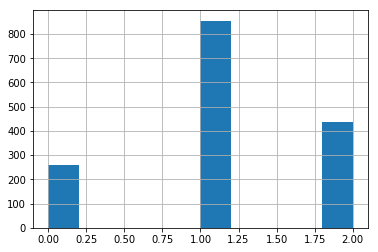

In [28]:
ds['prediction'].hist()
pass